### Greg's edits of Felipe's version of Song's code for MCMC

modified from Song's `hsc_um2` repo

In [2]:
# %load_ext line_profiler
from __future__ import division, print_function, unicode_literals

import time
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt

import emcee
print(emcee.__version__) #need version 3 (pip install emcee==3.0rc1)
import yaml

from scipy.stats import gaussian_kde

from astropy.table import Table, Column
from astropy.io import ascii, fits
from astropy.cosmology import FlatLambdaCDM

from halotools.sim_manager import TabularAsciiReader, HaloTableCache, CachedHaloCatalog
from halotools.sim_manager.rockstar_hlist_reader import RockstarHlistReader
from halotools.empirical_models import PrebuiltSubhaloModelFactory
from halotools.mock_observables import delta_sigma_from_precomputed_pairs, total_mass_enclosed_per_cylinder
from halotools.utils import randomly_downsample_data

/Users/astro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.0rc1


## parse config file 
**Greg: the config file needs a lot of updating. Missing a few files needed I believe.**


Values I don't understand completely or have that I know of (from Felipe's file):
* `mcmc_prefix`
* `cosmos_catalog_reference` -> I know mine are the HSC, not COSMOS
* `cosmos_SMF_points_file`
* Some of the things under Simulation
* `sim_halo_cat_file`
* `sim_particle_file`

I'm sure I'm just being stupid, but I don't know exactly what this needs. I know the simulation we use is the UM, but I don't know if what I have is what I need.

In [3]:
def parse_config(config_file):
    """Prepare configurations.
    Read configuration parameters from an input .yaml file.
    """
    cfg = yaml.load(open(config_file))

    return cfg
config_initial = parse_config('/Users/astro/desktop/github/dwarf_lensing/greg_mcmc/mcmc_default_config_greg.yaml')
print(config_initial) # need to update the config file for my project

{'model_type': 'scatter_only', 'param_ini': [0.4, 0.2], 'param_low': [0.0, 0.0], 'param_upp': [1.0, 1.0], 'param_sig': [0.1, 0.1], 'mcmc_out_dir': '/Users/astro/Desktop/GitHub/dwarf_lensing/greg_mcmc/', 'mcmc_prefix': 'cosmos_bplanck', 'mcmc_nsamples': 200, 'mcmc_nthreads': 2, 'mcmc_nburnin': 100, 'mcmc_nwalkers_burnin': 128, 'mcmc_nwalkers': 128, 'mcmc_smf_only': False, 'mcmc_wl_only': False, 'mcmc_wl_weight': 1.0, 'mcmc_ndims': 6, 'mcmc_moves_burnin': 'walk', 'mcmc_walk_s': 1, 'cosmos_dir': '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/cosmos/', 'cosmos_catalog_reference': 'Laigle+2016', 'cosmos_SMF_fit_file': 'cosmos2015_dic2017_smf_z01-04_STY0.dat', 'cosmos_SMF_points_file': 'cosmos2015_dic2017_smf_z01-04_Vmax0_with_header.dat', 'cosmos_wl_file': 'dwarf_all_lens_laigle2015_nozp2.out', 'n_dwarfs': 6876, 'mean_mass': 8.52695, 'mean_z': 0.301442, 'n_objects_with_specz': 1153, 'frac_objects_with_specz': 0.167685, 'cosmos_h0': 0.7, 'cosmos_omega_m': 0.3, 'sim_dir': '/Users/fardila

In [6]:
# take a look at the data files from Song
# these are different in that the data are stored in .npy format
pth = '/users/astro/desktop/github/dwarf_lensing/'
smf_data_file = pth + 'greg_mcmc/s16a_wide2_massive_smf_mmax_11.6.npy'

# load file into a table so I can see what it contains
smf_table = Table(np.load(smf_data_file))
smf_table

logm_mean,logm_0,logm_1,smf,smf_err,smf_low,smf_upp
float64,float64,float64,float64,float64,float64,float64
11.649999999999999,11.6,11.7,0.00017116160712174453,1.2081427708870142e-05,0.0001590801794128744,0.00018324303483061466
11.75,11.7,11.8,8.475233611275719e-05,7.806133691041449e-06,7.694620242171575e-05,9.255846980379864e-05
11.850000000000001,11.8,11.9,3.543046843019661e-05,4.301537386569409e-06,3.1128931043627195e-05,3.973200581676602e-05
11.95,11.9,12.0,1.2972069549804793e-05,2.8026394763069886e-06,1.0169430073497804e-05,1.577470902611178e-05
12.05,12.0,12.1,3.1444858281391925e-06,1.2682871836247533e-06,1.8761986445144392e-06,4.412773011763946e-06
12.149999999999999,12.1,12.200000000000001,8.795233942558793e-07,6.436421691529152e-07,2.3588122510296407e-07,1.5231655634087944e-06
12.25,12.200000000000001,12.3,1.826666675501702e-07,2.8710562153787887e-07,1e-08,4.6977228908804907e-07


## define global variables for config and data files
* Greg: I'm going to scan these functions and take out the lensing parts

In [9]:
def load_observed_data(cfg, verbose=True):
    """Load the observed data."""

    #SMF
    cosmos_SMF_fit_table = np.load(os.path.join(cfg['hsc_dir'],
                                       cfg['cosmos_hsc_fit_file']))
    cosmos_SMF_points_table = ascii.read(os.path.join(cfg['hsc_dir'],
                                       cfg['cosmos_SMF_points_file']))

#     cosmos_SMF_fit_m = cosmos_SMF_fit_table['log_m']
#     cosmos_SMF_fit_phi = cosmos_SMF_fit_table['log_phi']
#     cosmos_SMF_points_m = cosmos_SMF_points_table['logM']
#     cosmos_SMF_points_phi = cosmos_SMF_points_table['Phi']       

    
    #cosmology
    cfg['cosmos_cosmo'] = FlatLambdaCDM(H0=cfg['cosmos_h0'] * 100,
                                     Om0=cfg['cosmos_omega_m'])
    
#     obs_volume = ((cfg['obs_cosmo'].comoving_volume(obs_zmax) -
#                    cfg['obs_cosmo'].comoving_volume(obs_zmin)) *
#                   (cfg['obs_area'] / 41254.0)).value
#     cfg['obs_volume'] = obs_volume

    return {'cosmos_wl_r': cosmos_wl_r, 'cosmos_SMF_fit_table': cosmos_SMF_fit_table, 
            'cosmos_SMF_points_table': cosmos_SMF_points_table}, cfg

def load_sim_data(cfg):
    """Load the UniverseMachine data."""
    
    
    #read in halocat    
    halocat = CachedHaloCatalog(simname = cfg['sim_name'], halo_finder = cfg['sim_halo_finder'], 
                            version_name = cfg['sim_version_name'], redshift = cfg['sim_z'],
                                ptcl_version_name=cfg['sim_ptcl_version_name']) # doctest: +SKIP

    #read in particle table
    ptcl_table = Table.read(os.path.join(cfg['sim_dir'], cfg['sim_particle_file']), path='data')
    px = ptcl_table['x']
    py = ptcl_table['y']
    pz = ptcl_table['z']
    particles = np.vstack((px, py, pz)).T
    ptcl_table = 0
    
    #downsample 
    num_ptcls_to_use = int(1e4)
    particles = randomly_downsample_data(particles, num_ptcls_to_use)
    particle_masses = np.zeros(num_ptcls_to_use) + halocat.particle_mass
    downsampling_factor = (cfg['sim_particles_per_dimension']**3)/float(len(particles))
    
    #other parameters
    cfg['sim_cosmo'] = FlatLambdaCDM(H0=cfg['sim_h0'] * 100.0,
                                    Om0=cfg['sim_omega_m'])

    cfg['sim_volume'] = np.power(cfg['sim_lbox'] / cfg['sim_h0'], 3)
#     if verbose:
#         print("# The volume of the UniverseMachine mock is %15.2f Mpc^3" %
#               cfg['um_volume'])
        
#     return {'um_mock': um_mock_use[mask_mass],
#             'um_mass_encl': um_mass_encl[mask_mass, :],
#             'mask_central': mask_central[mask_mass]}

    return {'halocat' : halocat, 'particles' : particles,
            'particle_masses' : particle_masses, 'downsampling_factor' : downsampling_factor}, cfg

In [10]:
def setup_model(cfg, verbose=True):
    """Configure MCMC run and plots."""
    
    if cfg['model_type'] == 'scatter_only':
        # Number of parameters
        cfg['mcmc_ndims'] = 2
        cfg['mcmc_labels'] = [r'$a$',
                              r'$b$']


#     # Degree of freedom for the model: This is actually WRONG
#     cfg['model_dof'] = (cfg['obs_smf_n_data'] + cfg['obs_dsigma_n_data'] -
#                         cfg['mcmc_ndims'])
    # --------------------------------------------------- #

    
    cfg['mcmc_burnin_file'] = os.path.join(
        cfg['mcmc_out_dir'], cfg['mcmc_prefix'] + '_burnin.npz')
    cfg['mcmc_run_file'] = os.path.join(
        cfg['mcmc_out_dir'], cfg['mcmc_prefix'] + '_run.npz')


    return cfg


In [11]:
def initial_model(config, verbose=True):
    """Initialize the A.S.A.P model."""
    # Configuration for COSMOS data
    data_obs, config_obs = load_observed_data(config, verbose=verbose)

    # Configuration for simulation data.
    data_sim, config_obs_sim = load_sim_data(config_obs)

    #setup model
    config_all = setup_model(config_obs_sim, verbose=verbose)

    return config_all, data_obs, data_sim

global config, cosmos_data, sim_data

# Load the data
config, cosmos_data, sim_data = initial_model(config_initial)

## setup model

In [16]:
def compute_SMF(model, config, nbins=100):
    
    #Read stellar masses
    M = model.mock.galaxy_table['stellar_mass'] 
    
    #Take logarithm
    logM = np.log10(M)                     

    #Survey volume in Mpc3
    L=config['sim_lbox']
    h0=config['sim_h0']
    V = (L/h0)**3                    
    
    #Unnormalized histogram and bin edges
    Phi,edg = np.histogram(logM,bins=nbins) 
    
    #Bin size
    dM    = edg[1] - edg[0]                 
    bin_centers   = edg[0:-1] + dM/2.
    
    #Normalize to volume and bin size
    Phi   = Phi / float(V) / dM             
    logPhi= np.log10(Phi)
    
    return bin_centers, logPhi




def predict_model(param, config, obs_data, sim_data,
                       constant_bin=False, return_all=False,
                       show_smf=False, show_dsigma=False):
    """Return all model predictions.
    Parameters
    ----------
    param: list, array, or tuple.
        Input model parameters.
    config : dict
        Configurations of the data and model.
    obs_data: dict
        Dictionary for observed data.
    sim_data: dict
        Dictionary for UniverseMachine data.
    constant_bin : boolen
        Whether to use constant bin size for logMs_tot or not.
    return_all : bool, optional
        Return all model information.
    show_smf : bool, optional
        Show the comparison of SMF.
    show_dsigma : bool, optional
        Show the comparisons of WL.
    """
    
    #build_model
    model = PrebuiltSubhaloModelFactory('behroozi10', redshift=config['sim_z'],
                                        scatter_abscissa=[12, 15], scatter_ordinates=[param[0], param[1]])
    #poluate mock catalog
    model.populate_mock(sim_data['halocat'])

    # Predict SMFs
    smf_mass_bins, smf_log_phi = compute_SMF(model,config, nbins=100)
    

#     if show_smf:
#         um_smf_tot_all = get_smf_bootstrap(logms_mod_tot_all,
#                                            cfg['um_volume'],
#                                            20, cfg['obs_min_mtot'], 12.5,
#                                            n_boots=1)
#         _ = plot_mtot_minn_smf(
#             obs_data['obs_smf_tot'], obs_data['obs_smf_inn'],
#             obs_data['obs_mtot'], obs_data['obs_minn'],
#             um_smf_tot, um_smf_inn,
#             logms_mod_tot, logms_mod_inn,
#             obs_smf_full=obs_data['obs_smf_full'],
#             um_smf_tot_all=um_smf_tot_all,
#             not_table=True)

#     if show_dsigma:
#         um_mhalo_tuple = asap_predict_mhalo(
#             obs_data['obs_wl_dsigma'], um_data['um_mock'][mask_mtot],
#             logms_mod_tot, logms_mod_inn)
#         _ = plot_dsigma_profiles(obs_data['obs_wl_dsigma'],
#                                  um_dsigma_profs, obs_mhalo=None,
#                                  um_mhalo=um_mhalo_tuple)



    return smf_mass_bins, smf_log_phi

In [17]:
parameters = list(config['param_ini'])
print(parameters)
# Generate the model predictions
sim_smf_mass_bins, sim_smf_log_phi = predict_model(parameters, config, cosmos_data, sim_data)       

[0.4, 0.2]


## plotting functions

In [7]:
def plot_SMF(sim_mass_centers, sim_logPhi, cosmos_SMF_points_table, cosmos_SMF_fit_table):
    
    #plot sim
    plt.plot(sim_mass_centers, sim_logPhi, c='r', label='Bolshoi-Planck halos')
    
    #plot COSMOS
    plt.plot(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi'], label='COSMOS z~0.2 fit')
    plt.fill_between(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi_inf'], 
                     cosmos_SMF_fit_table['log_phi_sup'], alpha=0.5)
    plt.errorbar(cosmos_SMF_points_table['logM'], cosmos_SMF_points_table['Phi'], 
                 yerr=[cosmos_SMF_points_table['Phi_err+'],cosmos_SMF_points_table['Phi_err-']], fmt='o', elinewidth=3,
                markersize=5, c='#1f77b4', label='COSMOS z~0.2 points')

    #plot details
    plt.xlabel('log(M)')
    plt.ylabel('log(Phi)')
    plt.xlim([8,12.5])
    plt.ylim([-10,0])
    plt.legend(loc='lower left')
    
    plt.show()

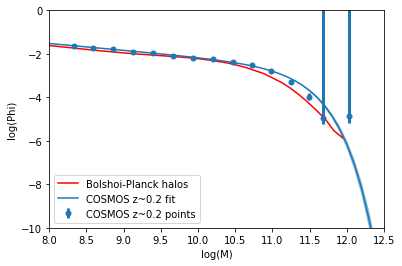

In [51]:
plot_SMF(sim_smf_mass_bins, sim_smf_log_phi, cosmos_data['cosmos_SMF_points_table'],
         cosmos_data['cosmos_SMF_fit_table'])

## probability functions

In [8]:
def flat_prior(param_tuple, param_low, param_upp):
    """Priors of parameters. Return -inf if all parameters are not within bounds."""
    if not np.all([low <= param <= upp for param, low, upp in
                   zip(list(param_tuple), param_low, param_upp)]):
        return -np.inf

    return 0.0

def smf_lnlike(obs_smf_fit_table, obs_smf_points_table, sim_smf_mass_bins, sim_smf_log_phi):
    """Calculate the likelihood for SMF."""
    
    #get same bins in simulations as in observations 
    sim_smf_log_phi_interpolated = np.interp(obs_smf_points_table['logM'], sim_smf_mass_bins, sim_smf_log_phi)
    
    #difference
    smf_diff = (np.array(sim_smf_log_phi_interpolated) - np.array(obs_smf_points_table['Phi']))
    
    #variance
    obs_mean_smf_error = np.mean([obs_smf_points_table['Phi_err+'] , obs_smf_points_table['Phi_err-'] ])
    smf_var = np.array(obs_mean_smf_error ** 2)

    #chi2
    smf_chi2 = (smf_diff ** 2 / smf_var).sum()

    #likelihood
    smf_lnlike = -0.5 * (smf_chi2 + np.log(2 * np.pi * smf_var).sum())


    # print("SMF Tot lnlike/chi2: %f,%f" % (smf_mtot_lnlike,
    #                                       smf_mtot_chi2))


    return smf_lnlike


def ln_like(param_tuple, config, obs_data, sim_data, chi2=False,
                 sep_return=False):
    """Calculate the lnLikelihood of the model."""
    # Unpack the input parameters
    parameters = list(param_tuple)

    # Generate the model predictions
    sim_smf_mass_bins, sim_smf_log_phi = predict_model(parameters, config, obs_data, sim_data)   

    # Likelihood for SMFs.
    smf_lnlike_value = smf_lnlike(obs_data['cosmos_SMF_fit_table'], obs_data['cosmos_SMF_points_table'],
        sim_smf_mass_bins, sim_smf_log_phi)



    return smf_lnlike_value 

def ln_prob_global(param_tuple):
    """Probability function to sample in an MCMC.

    Parameters
    ----------
    param_tuple: tuple of model parameters.

    """
    lp = flat_prior(param_tuple, config['param_low'], config['param_upp'])

    if not np.isfinite(lp):
        return -np.inf

    return lp + ln_like(param_tuple, config, cosmos_data, sim_data)

In [84]:
smf_lnlike(cosmos_data['cosmos_SMF_fit_table'], cosmos_data['cosmos_SMF_points_table'],
           sim_smf_mass_bins, sim_smf_log_phi)

-5.119408850385905

In [13]:
%lprun -f predict_model ln_like(config['param_ini'], config, cosmos_data, sim_data)

## setup mcmc functions 

In [10]:
def mcmc_initial_guess(param_initial, param_sigma, n_walkers, n_dims):
    """Initialize guesses for the MCMC run. One guess for each dimension (model parameter) per walker,
    with a small sigma deviation from param_initial. """
    mcmc_position = np.zeros([n_walkers, n_dims])

    for ii, param_0 in enumerate(param_initial):
        mcmc_position[:, ii] = (param_0 + param_sigma[ii] * np.random.randn(n_walkers))

    return mcmc_position

def mcmc_setup_moves(config, move_col):
    """Choose the Move object for emcee."""
    if config[move_col] == 'snooker':
        emcee_moves = emcee.moves.DESnookerMove()
    elif config[move_col] == 'stretch':
        emcee_moves = emcee.moves.StretchMove(a=config['mcmc_stretch_a'])
    elif config[move_col] == 'walk':
        emcee_moves = emcee.moves.WalkMove(s=config['mcmc_walk_s'])
    elif config[move_col] == 'kde':
        emcee_moves = emcee.moves.KDEMove()
    elif config[move_col] == 'de':
        emcee_moves = emcee.moves.DEMove(config['mcmc_de_sigma'])
    else:
        raise Exception("Wrong option: stretch, walk, kde, de, snooker")
    
    return emcee_moves

def mcmc_burnin(mcmc_sampler, mcmc_position, config, verbose=True):
    """Run the MCMC chain."""
    # Burn-in
    if verbose:
        print("# Phase: Burn-in ...")
    mcmc_burnin_result = mcmc_sampler.run_mcmc(
        mcmc_position, config['mcmc_nburnin'],
        progress=True)

    mcmc_save_results(mcmc_burnin_result, mcmc_sampler,
                      config['mcmc_burnin_file'], config['mcmc_ndims'],
                      verbose=True)

    # Rest the chains
    mcmc_sampler.reset()

## run fit

In [11]:
#skip paralleization for now
def emcee_fit(config, verbose=True):
    # Initialize the model
    mcmc_ini_position = mcmc_initial_guess(
        config['param_ini'], config['param_sig'], config['mcmc_nwalkers'],
        config['mcmc_ndims'])

    # define the ensemble moves object for walkers during burn in
    burnin_move = mcmc_setup_moves(config, 'mcmc_moves_burnin')
    # define sampler
    burnin_sampler = emcee.EnsembleSampler(
        config['mcmc_nwalkers_burnin'],
        config['mcmc_ndims'],
        ln_prob_global,
        moves=burnin_move) #,pool=pool)

    # Burn-in
    mcmc_burnin_pos, mcmc_burnin_lnp, mcmc_burnin_state = mcmc_burnin(
        burnin_sampler, mcmc_ini_position, config, verbose=True)

    # Estimate the Kernel density distributions of final burn-in positions
    # Resample the distributions to get starting positions of the actual run
    mcmc_kde = gaussian_kde(np.transpose(mcmc_burnin_pos), 
                        bw_method='silverman')
    mcmc_new_pos = np.transpose(mcmc_kde.resample(config['mcmc_nwalkers']))

    mcmc_new_ini = (mcmc_new_pos, mcmc_burnin_lnp, mcmc_burnin_state)

    
    # MCMC run
    
    # Decide the Ensemble moves for walkers during burnin
    emcee_move = mcmc_setup_moves(config, 'mcmc_moves')
    # define sampler
    mcmc_sampler = emcee.EnsembleSampler(config['mcmc_nwalkers'],
                                         config['mcmc_ndims'],
                                         ln_prob_global,
                                         moves=emcee_move)

    mcmc_run_result = emcee_run(mcmc_sampler, mcmc_new_ini, config, verbose=True)

    return mcmc_run_result

In [12]:
emcee_fit(config)

# Phase: Burn-in ...
[0.01, 0.01598922, 0.02947921, 0.05184152, 0.09251636, 0.1643359, 0.29233885, 0.51980176, 0.92438561]
[0.01, 0.01598922, 0.02947921, 0.05184152, 0.09251636, 0.1643359, 0.29233885, 0.51980176, 0.92438561]
[0.01, 0.01598922, 0.02947921, 0.05184152, 0.09251636, 0.1643359, 0.29233885, 0.51980176, 0.92438561]
[0.01, 0.01598922, 0.02947921, 0.05184152, 0.09251636, 0.1643359, 0.29233885, 0.51980176, 0.92438561]
emcee: Exception while calling your likelihood function:
  params: [0.42561224 0.05707932]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/fardila/anaconda/envs/dwarf_lensing/lib/python2.7/site-packages/emcee/ensemble.py", line 488, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-9-225398fa960b>", line 89, in ln_prob_global
    return lp + ln_like(param_tuple, config, cosmos_data, sim_data)
  File "<ipython-input-9-225398fa960b>", line 62, in ln_like
    sim_smf_mass_bins, sim_smf_log_phi, sim_wl_r, sim_wl_ds = predict_model(parameters, config, obs_data, sim_data)
  File "<ipython-input-7-52d751ba68b5>", line 93, in predict_model
    model.populate_mock(sim_data)
  File "/Users/fardila/anaconda/envs/dwarf_lensing/lib/python2.7/site-packages/halotools/empirical_models/factories/subhalo_model_factory.py", line 900, in populate_mock
    ModelFactory.populate_mock(self, halocat, **kwargs)
  File "/Users/fardila/anaconda/envs/dwarf_lensing/lib/python2.7/site-packages/halotools/empirical_models/factories/model_factory_template.py", line 231, in

KeyboardInterrupt: 